In [41]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Sep 15 14:32:01 2018

@author: filip
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
os.chdir("/Volumes/GoogleDrive/Min enhet/Boende/Ekonomi/Cash flow")

#### Load the data ####
bank_data = pd.read_csv("Nordea_main.csv")
bank_data = bank_data.sort_index()

bank_data["DATUM:"] = pd.to_datetime(bank_data["DATUM:"], 
                                     format="%Y-%m-%d", utc=True)
bank_data = bank_data.set_index("DATUM:")

In [42]:
bank_data.head()

,BELOPP:,INFORMATION:,SALDO:,Unnamed: 0,balance,transaction
DATUM:,,,,,,
2015-01-02 00:00:00+00:00,"14 546,00‑",Utbetalning LB 745-7039,NaN,0.0,700223.0,NaN
2015-01-02 00:00:00+00:00,"3 710,00",BG INBETALNING 00001 745-7039,NaN,1.0,703933.0,NaN
2015-01-05 00:00:00+00:00,"24 652,00‑",Omsättning lån 3978 84 94757,NaN,3.0,674629.0,NaN
2015-01-05 00:00:00+00:00,"1 652,00",BG INBETALNING 00002 745-7039,NaN,5.0,699281.0,NaN
2015-01-05 00:00:00+00:00,"17 868,00‑",Utbetalning LB 745-7039,NaN,2.0,697629.0,NaN


In [43]:
# keep only the valid columns:
bank_data = bank_data[["transaction", "balance"]]
# Drop duplicates
bank_data = bank_data.drop_duplicates(keep = "first")
# Define daily balance as average during the day. Transaction becomes nonsensical from here!!!
bank_data = bank_data.groupby(bank_data.index.date).mean()
# Drop transaction
bank_data = bank_data["balance"]
# put back the index
bank_data.index = pd.to_datetime(bank_data.index, format="%Y-%m-%d", utc=True)
bank_data = bank_data.resample("D").mean()
# We know that during dates when there was no transaction, the balance was simply what it was yesterday.
# We use this fact to fill in dates without information.
bank_data = bank_data.fillna(method = "ffill")

In [44]:
#### Forecast using SARIMAX
mod = sm.tsa.statespace.SARIMAX(bank_data.resample("M").mean(), order=(0, 0, 2),
                                seasonal_order=(0, 1, 0, 12),
                                trend = "t")
arima_results = mod.fit()
print(arima_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift        1.04e+04   1594.119      6.526      0.000    7278.165    1.35e+04
ma.L1          0.5156      0.165      3.123      0.002       0.192       0.839
ma.L2          0.4844      0.216      2.245      0.025       0.062       0.907
sigma2      2.158e+10   5.11e-05   4.22e+14      0.000    2.16e+10    2.16e+10


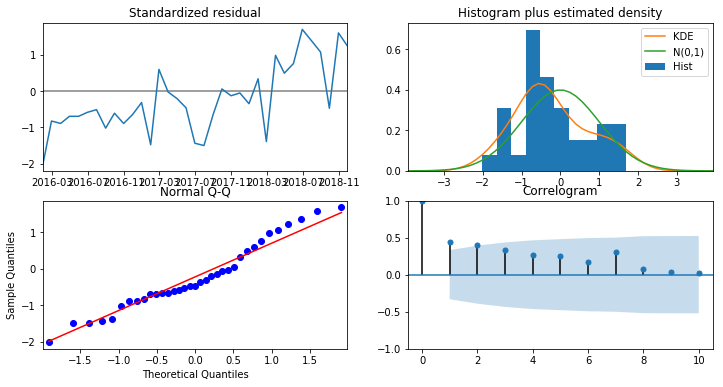

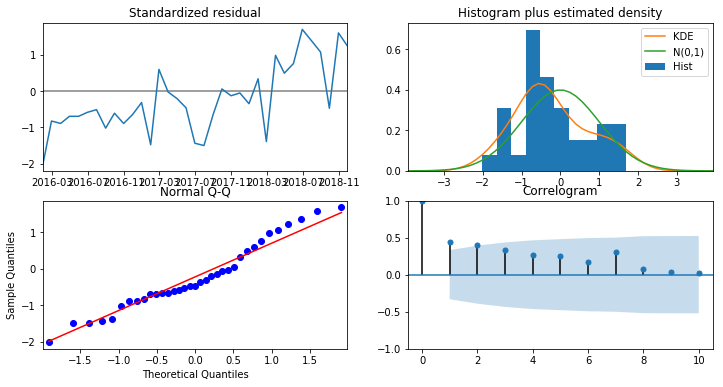

In [45]:
# Diagnostics:
arima_results.plot_diagnostics(figsize=(12, 6))

Not having actually started the time series course yet, the interpretation might be a bit wacky. Hopefully I'll know better in March, prior to the exam. 

Anyway, the standardised residual (top left) does not look like white noise. This means there is some systematic effect going on. The residual seems to be going from negative values to positive values, which might indicate that the linear trend is not a good fit. Theoretically, this makes perfect sense since we didn't have a tenant prior to around that period. Future models should control for this using an indicator variable.

Top right, the orange curve has too much density on the negative side. I don't know if this approximation is good enough.

Bottom left, this too, seems to suggest non normality, but it is not terribly off.

Bottom right, all the lagged correlations are positive, but a more complex model with more lags would probably not make it better since these are all non significant. Intuitvely, the positive correlation of error terms likely reflects that we have not controlled for tenant occupancy yet.

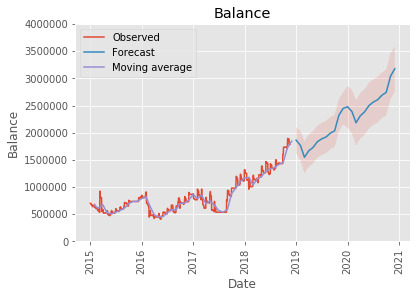

In [47]:
# visualising the forecast:
pred_uc = arima_results.get_forecast(steps=24)
pred_ci = pred_uc.conf_int(alpha = 0.1)

with plt.style.context("ggplot"):
    fig = plt.figure()
    ax = plt.axes()
    ax.set_ylim(0,4000000)
    plt.xticks(rotation = 90)
    plt.title("Balance")
    ax.set_xlabel("Date")
    ax.set_ylabel("Balance")
    ax.plot(bank_data, label = "Observed")
    ax.plot(pred_uc.predicted_mean, label = "Forecast")
    ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], alpha=.15)
    ax.plot(bank_data.resample("M").mean(), label = "Moving average")
    plt.legend()
    plt.show()

According to the chart, there is a negative cashflow following the cold months reflecting the seasonality of the energy bill. Furthermore, the forecast is naïve in the sense that it does not take any amortizations/new loans into account. During the period end of 2015 to end of 2018, long term debt went from MSEK 16.56 to MSEK 16. As a visual check, it looks about right since it is what I would have expected. From the diagnostics and the fact that we used to amortise but don't do that anymore, there are some good reasons to believe this is underestimating actual future cash flow and can feel confident the balance won't go below MSEK 1.5 as a result of our running operations.

To conclude, the board can confidently make cash flow decisions based on: 

$$I < MSEK1.5 + credit \: lines - min.\: balance \approx MSEK3.3$$

during the year and not risk liquidity at any point in time.